

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=15,
    # randomly shift images horizontally
    width_shift_range=0.05,
    # randomly shift images vertically
    height_shift_range=0.05,
    # randomly flip images
    horizontal_flip=False,
    # randomly flip images
    vertical_flip=False
)    


output_path = os.path.abspath('./output')
data_name = 'mnist'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(60000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.4, 'layer_count':1, 'units':128, 'epochs':15},
        'lenet':{'dropout':0.2, 'epochs':15}, 
        'lenet':{'dropout':0.2, 'epochs':15},
        'custom':{'dropout':0.3, 'epochs':15},
        'vgg':{'dropout':0.4, 'epochs':15},
        'resnet':{'epochs':15}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 06:05:27,678: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 增加一个通道
train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1) 


print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

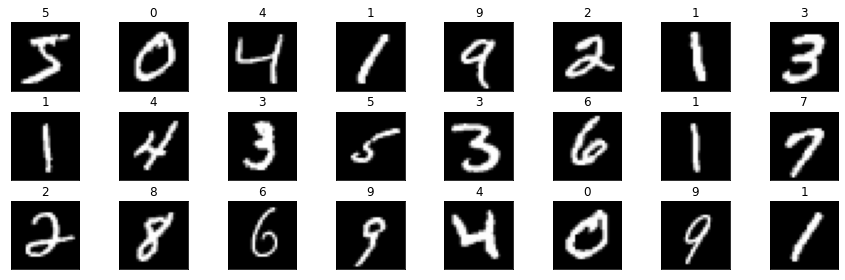

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

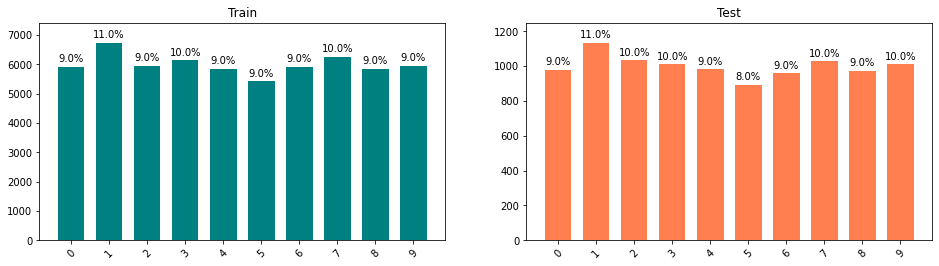

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 28, 28, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

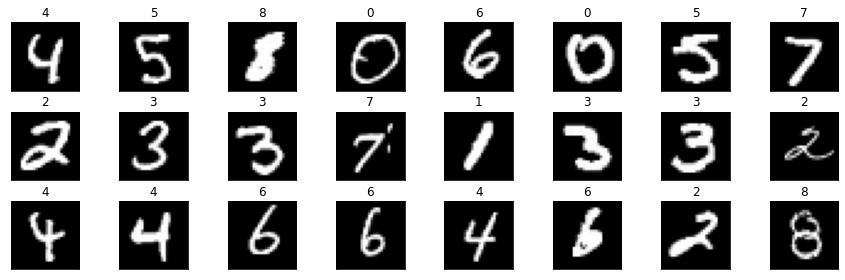

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

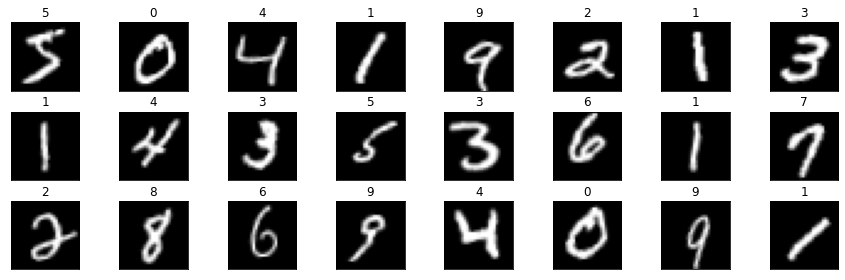

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

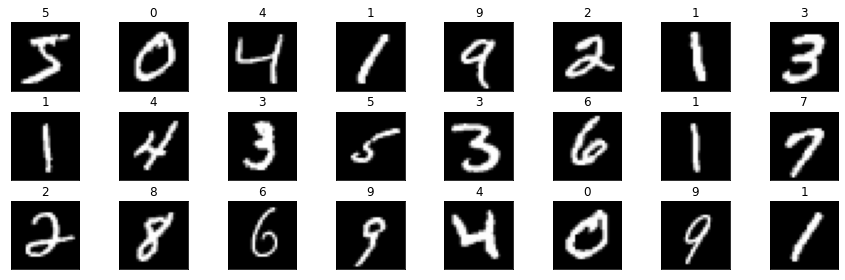

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


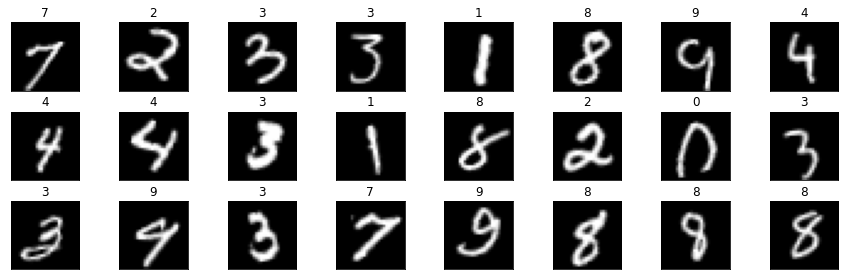

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 06:05:37,042: INFO: model_params.mlp1.dropout=0.4
2021-08-10 06:05:37,042: INFO: model_params.mlp1.layer_count=1
2021-08-10 06:05:37,043: INFO: model_params.mlp1.units=128
2021-08-10 06:05:37,098: INFO: learning_rate=0.001
2021-08-10 06:05:37,099: INFO: model_params.mlp1.clip_value=None
2021-08-10 06:05:37,117: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1
2021-08-10 06:05:37,120: INFO: model_params.mlp1.epochs=15
2021-08-10 06:05:37,120: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1, monitor=val_accuracy)
2021-08-10 06:05:37,121: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 06:05:37,122: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 06:05:37,122: INFO: use LearningRateScheduler()
2021-08-10 06:05:37,123: INFO

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.uint8, name=None)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1875/1875 [==============================] - 5s 2m

2021-08-10 06:05:42,444: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 2/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9097 - accuracy: 0.7433 - val_loss: 0.4942 - val_accuracy: 0.8866
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 06:05:46,719: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 3/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7566 - accuracy: 0.7863 - val_loss: 0.4165 - val_accuracy: 0.9067
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 06:05:50,994: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 4/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6733 - accuracy: 0.8140 - val_loss: 0.3586 - val_accuracy: 0.9176
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 06:05:55,102: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 5/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6169 - accuracy: 0.8307 - val_loss: 0.3484 - val_accuracy: 0.9184
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 06:05:59,295: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 6/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5725 - accuracy: 0.8395 - val_loss: 0.3344 - val_accuracy: 0.9251
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 06:06:03,456: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 7/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5599 - accuracy: 0.8472 - val_loss: 0.3244 - val_accuracy: 0.9266
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 06:06:07,676: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 8/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5463 - accuracy: 0.8496 - val_loss: 0.3501 - val_accuracy: 0.9323
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 06:06:11,833: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 9/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5536 - accuracy: 0.8519 - val_loss: 0.3203 - val_accuracy: 0.9303
Epoch 10/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5240 - accuracy: 0.8530 - val_loss: 0.3641 - val_accuracy: 0.9322
Epoch 11/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5316 - accuracy: 0.8553 - val_loss: 0.3426 - val_accuracy: 0.9298
Epoch 12/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5187 - accuracy: 0.8608 - val_loss: 0.3528 - val_accuracy: 0.9336
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


2021-08-10 06:06:26,920: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1/assets


Epoch 13/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5156 - accuracy: 0.8628 - val_loss: 0.3559 - val_accuracy: 0.9287
Epoch 14/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4981 - accuracy: 0.8655 - val_loss: 0.3697 - val_accuracy: 0.9283
Epoch 15/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5112 - accuracy: 0.8624 - val_loss: 0.3443 - val_accuracy: 0.9266


2021-08-10 06:06:38,201: INFO: finish training [elapsed time: 61.08 seconds]


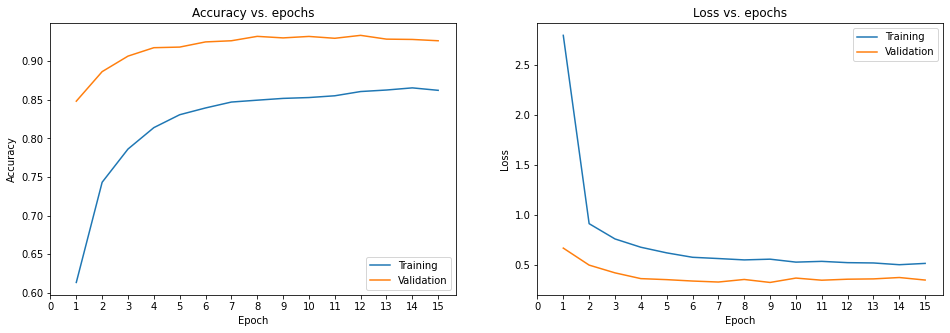

2021-08-10 06:06:38,653: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 06:06:43,477: INFO: test loss:0.3528
2021-08-10 06:06:43,478: INFO: test accuracy:0.9336
2021-08-10 06:06:43,479: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:06:43,481: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:06:43,482: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:06:43,483: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:06:43,484: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:06:45,450: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator


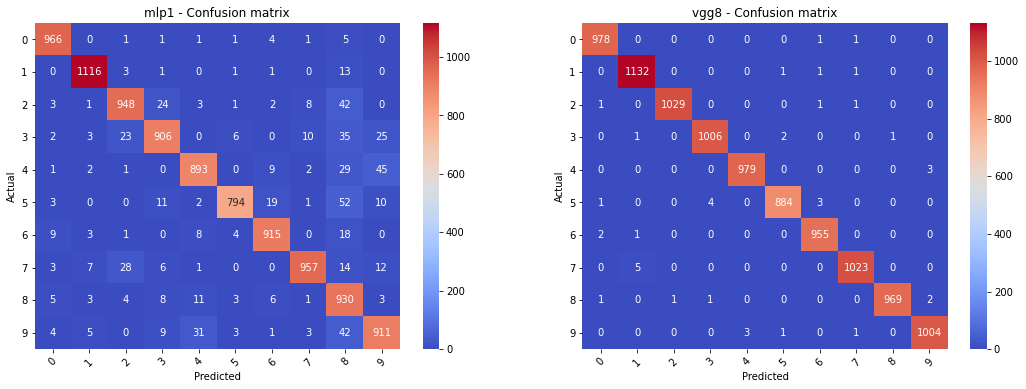

2021-08-10 06:06:49,565: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 06:06:51,231: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:06:51,233: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
2021-08-10 06:06:52,162: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:06:52,164: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
2021-08-10 06:06:52,958: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:06:52,960: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output

2021-08-10 06:06:59,279: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fc44422c598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


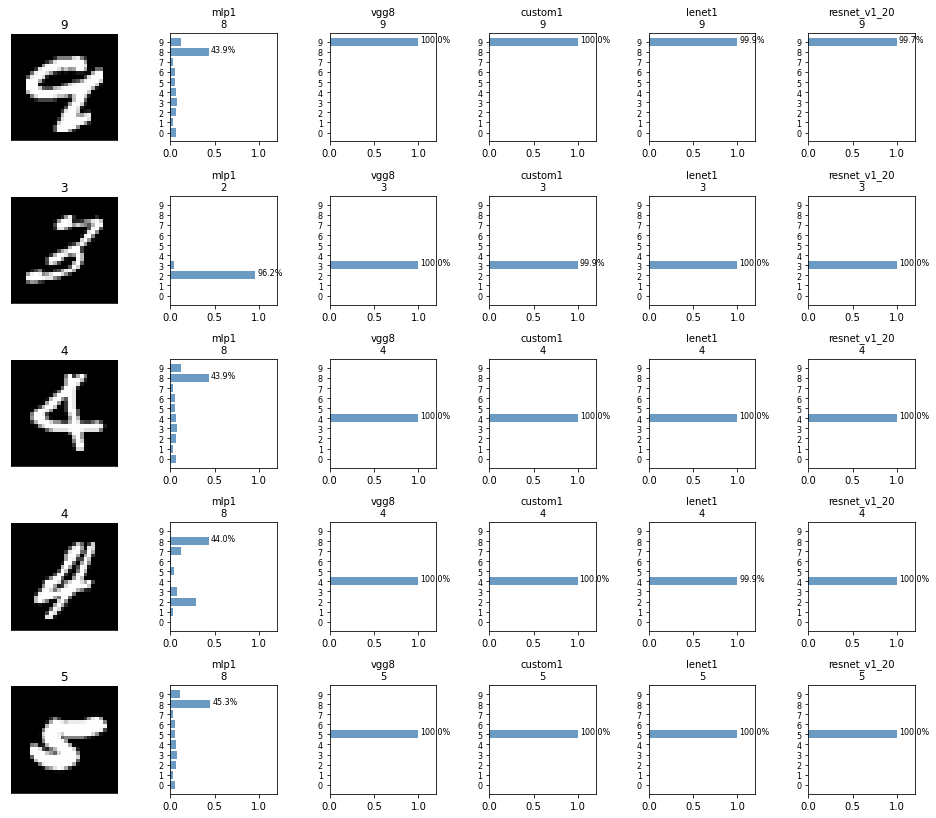

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,265.3,0.0098,0.0160,0.9967,0.9959,1.0000,1.0000
2,custom1,73162,148.2,0.0102,0.0247,0.9969,0.9933,1.0000,1.0000
3,lenet1,61750,128.2,0.0141,0.0271,0.9956,0.9920,1.0000,0.9999
4,resnet_v1_20,272778,602.4,0.0790,0.0854,0.9897,0.9882,0.9999,0.9999
5,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965
6,mlp1,101770,60.6,0.2428,0.3528,0.9392,0.9336,0.9962,0.9944


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-08-10 06:07:03,496: INFO: model_params.lenet1.dropout=0.2


TensorSpec(shape=(32, 28, 28, 1), dtype=tf.uint8, name=None)


2021-08-10 06:07:03,575: INFO: learning_rate=0.001
2021-08-10 06:07:03,576: INFO: model_params.lenet1.clip_value=None
2021-08-10 06:07:03,582: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
2021-08-10 06:07:03,586: INFO: model_params.lenet1.epochs=15
2021-08-10 06:07:03,587: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1, monitor=val_accuracy)
2021-08-10 06:07:03,587: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 06:07:03,588: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 06:07:03,589: INFO: use LearningRateScheduler()
2021-08-10 06:07:03,589: INFO: steps_per_epoch=1875
2021-08-10 06:07:03,590: INFO: start training
2021-08-10 06:07:03,590: INFO: use_class_weight=False


Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64   

2021-08-10 06:07:14,430: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 2/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1134 - accuracy: 0.9661 - val_loss: 0.0691 - val_accuracy: 0.9811
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 06:07:24,581: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 3/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0878 - accuracy: 0.9749 - val_loss: 0.0504 - val_accuracy: 0.9860
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 06:07:34,353: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 4/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0767 - accuracy: 0.9779 - val_loss: 0.0384 - val_accuracy: 0.9875
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 06:07:44,328: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 5/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0650 - accuracy: 0.9809 - val_loss: 0.0388 - val_accuracy: 0.9877
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 06:07:54,241: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 6/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0639 - accuracy: 0.9801 - val_loss: 0.0499 - val_accuracy: 0.9844
Epoch 7/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0579 - accuracy: 0.9828 - val_loss: 0.0314 - val_accuracy: 0.9900
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 06:08:12,765: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 8/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0534 - accuracy: 0.9846 - val_loss: 0.0330 - val_accuracy: 0.9896
Epoch 9/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 0.0317 - val_accuracy: 0.9904
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 06:08:30,842: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 10/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0518 - accuracy: 0.9845 - val_loss: 0.0269 - val_accuracy: 0.9912
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


2021-08-10 06:08:41,009: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1/assets


Epoch 11/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0487 - accuracy: 0.9853 - val_loss: 0.0312 - val_accuracy: 0.9902
Epoch 12/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0459 - accuracy: 0.9864 - val_loss: 0.0285 - val_accuracy: 0.9910
Epoch 13/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.0298 - val_accuracy: 0.9911
Epoch 14/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0424 - accuracy: 0.9876 - val_loss: 0.0324 - val_accuracy: 0.9903
Epoch 15/15
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0398 - accuracy: 0.9876 - val_loss: 0.0350 - val_accuracy: 0.9902


2021-08-10 06:09:21,615: INFO: finish training [elapsed time: 138.03 seconds]


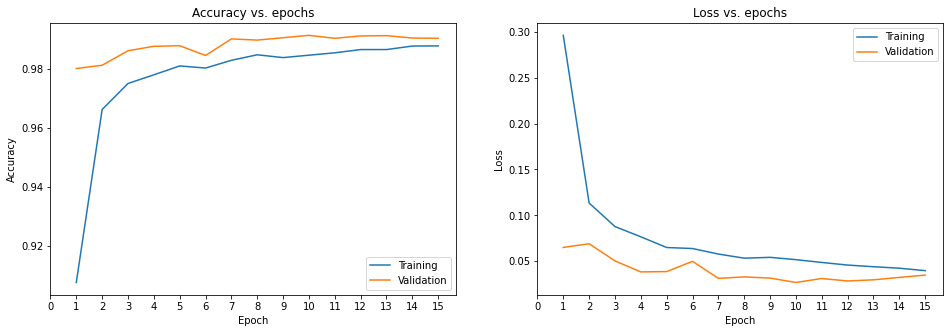

2021-08-10 06:09:22,168: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
----------------------------------------evaluate----------------------------------------


2021-08-10 06:09:30,686: INFO: test loss:0.0269
2021-08-10 06:09:30,687: INFO: test accuracy:0.9912
2021-08-10 06:09:30,688: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:09:30,690: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:09:30,690: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:09:30,691: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:09:30,692: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:09:32,683: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator


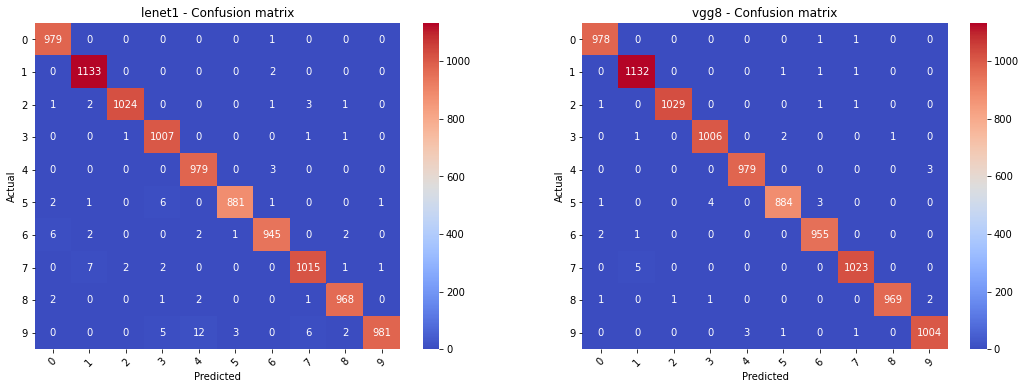

2021-08-10 06:09:36,221: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 06:09:37,737: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:09:37,740: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
2021-08-10 06:09:38,665: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:09:38,667: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20
2021-08-10 06:09:43,619: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:09:43,621: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/

2021-08-10 06:09:45,282: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fc3e8e59620> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


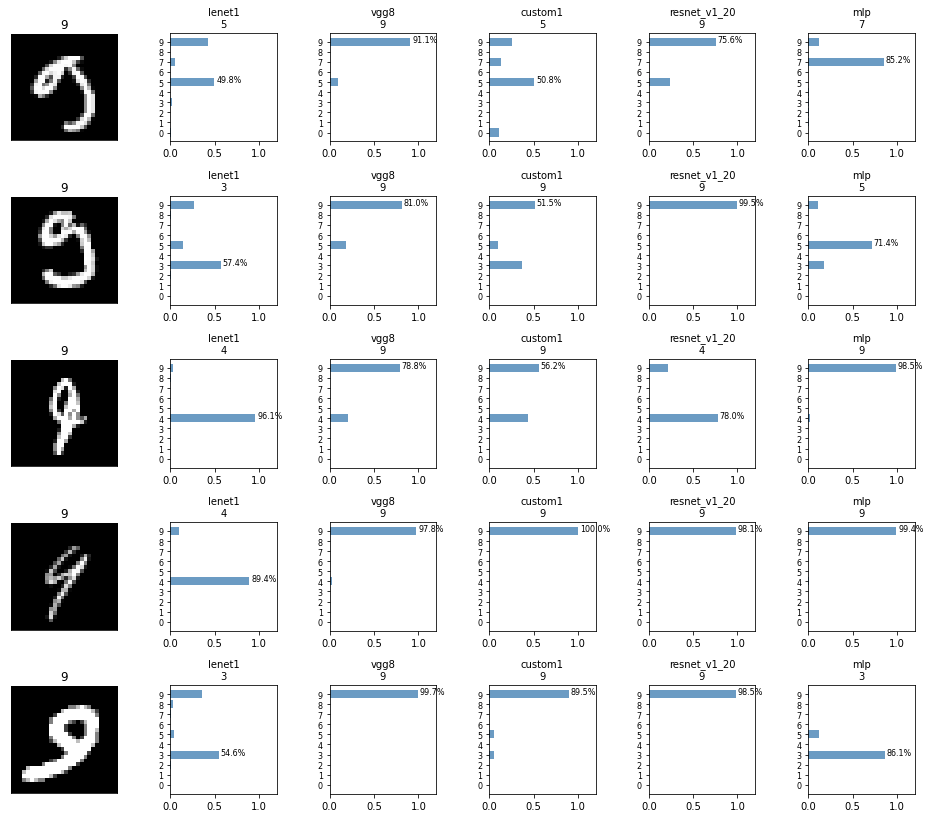

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,265.3,0.0098,0.0160,0.9967,0.9959,1.0000,1.0000
2,custom1,73162,148.2,0.0102,0.0247,0.9969,0.9933,1.0000,1.0000
3,lenet1,61750,137.5,0.0169,0.0269,0.9947,0.9912,1.0000,1.0000
4,resnet_v1_20,272778,602.4,0.0790,0.0854,0.9897,0.9882,0.9999,0.9999
5,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965
6,mlp1,101770,60.6,0.2428,0.3528,0.9392,0.9336,0.9962,0.9944


In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2021-08-10 06:09:49,949: INFO: model_params.custom1.dropout=0.3


TensorSpec(shape=(32, 28, 28, 1), dtype=tf.uint8, name=None)


2021-08-10 06:09:50,048: INFO: learning_rate=0.001
2021-08-10 06:09:50,049: INFO: model_params.custom1.clip_value=None
2021-08-10 06:09:50,055: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
2021-08-10 06:09:50,061: INFO: model_params.custom1.epochs=15
2021-08-10 06:09:50,061: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1, monitor=val_accuracy)
2021-08-10 06:09:50,062: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 06:09:50,062: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 06:09:50,063: INFO: use LearningRateScheduler()
2021-08-10 06:09:50,063: INFO: steps_per_epoch=1875
2021-08-10 06:09:50,064: INFO: start training
2021-08-10 06:09:50,065: INFO: use_class_weight=False


Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 64)        256 

2021-08-10 06:10:02,308: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 2/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1108 - accuracy: 0.9672 - val_loss: 0.0362 - val_accuracy: 0.9891
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 06:10:15,382: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 3/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0861 - accuracy: 0.9747 - val_loss: 0.0422 - val_accuracy: 0.9879
Epoch 4/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0717 - accuracy: 0.9789 - val_loss: 0.0293 - val_accuracy: 0.9904
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 06:10:37,141: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 5/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0650 - accuracy: 0.9803 - val_loss: 0.0307 - val_accuracy: 0.9909
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 06:10:48,597: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 6/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0600 - accuracy: 0.9825 - val_loss: 0.0285 - val_accuracy: 0.9904
Epoch 7/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0534 - accuracy: 0.9845 - val_loss: 0.0334 - val_accuracy: 0.9902
Epoch 8/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0546 - accuracy: 0.9837 - val_loss: 0.0262 - val_accuracy: 0.9914
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 06:11:18,527: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 9/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0505 - accuracy: 0.9846 - val_loss: 0.0267 - val_accuracy: 0.9919
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 06:11:30,274: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 10/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0464 - accuracy: 0.9864 - val_loss: 0.0266 - val_accuracy: 0.9919
Epoch 11/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0451 - accuracy: 0.9858 - val_loss: 0.0275 - val_accuracy: 0.9915
Epoch 12/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0430 - accuracy: 0.9869 - val_loss: 0.0240 - val_accuracy: 0.9932
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


2021-08-10 06:11:59,696: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1/assets


Epoch 13/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0401 - accuracy: 0.9873 - val_loss: 0.0251 - val_accuracy: 0.9931
Epoch 14/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0424 - accuracy: 0.9872 - val_loss: 0.0286 - val_accuracy: 0.9922
Epoch 15/15
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0395 - accuracy: 0.9880 - val_loss: 0.0298 - val_accuracy: 0.9914


2021-08-10 06:12:28,709: INFO: finish training [elapsed time: 158.65 seconds]


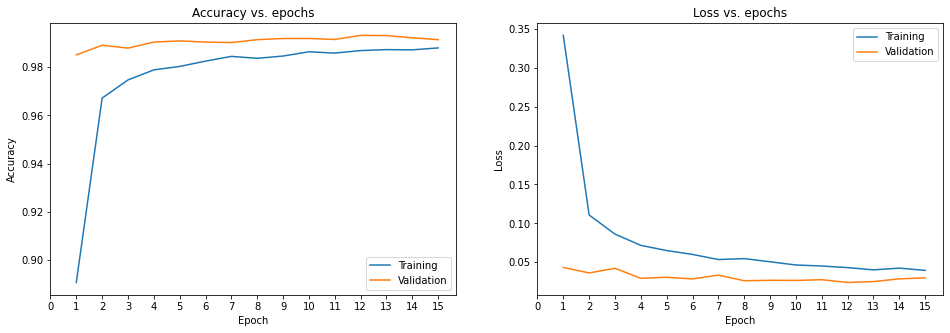

2021-08-10 06:12:29,199: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
----------------------------------------evaluate----------------------------------------


2021-08-10 06:12:39,090: INFO: test loss:0.0240
2021-08-10 06:12:39,091: INFO: test accuracy:0.9932
2021-08-10 06:12:39,093: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:12:39,096: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:12:39,096: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:12:39,098: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:12:39,098: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:12:41,260: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator


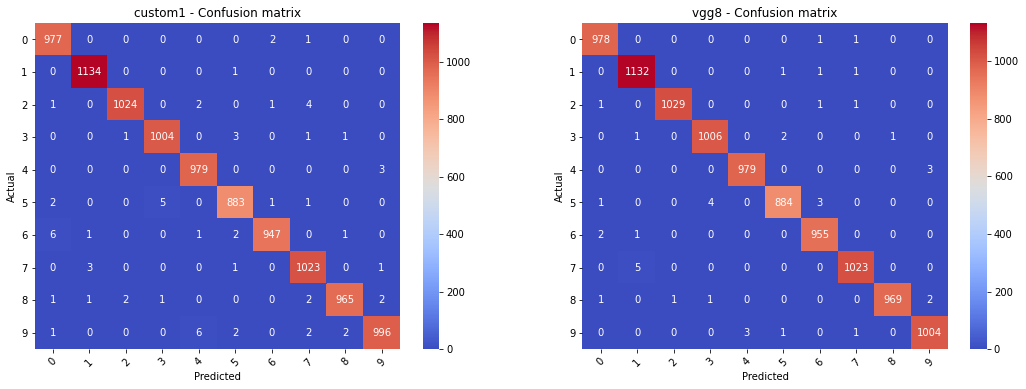

2021-08-10 06:12:45,063: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 06:12:46,625: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:12:46,628: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
2021-08-10 06:12:47,414: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:12:47,416: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20
2021-08-10 06:12:52,109: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:12:52,110: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/o

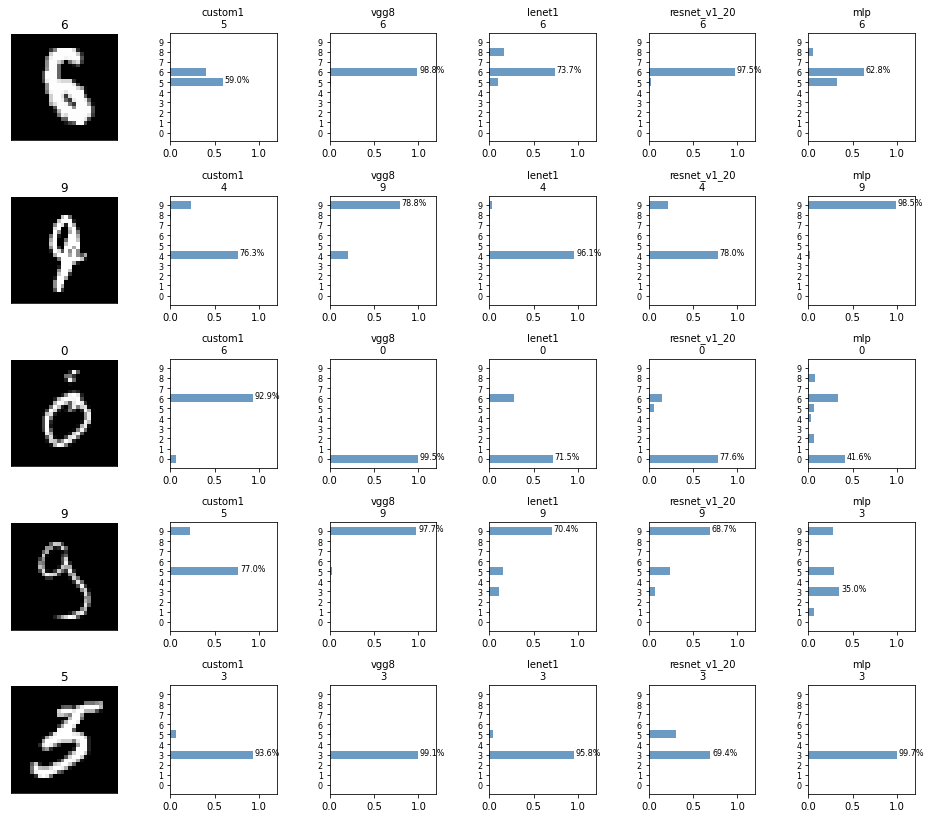

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,265.3,0.0098,0.0160,0.9967,0.9959,1.0000,1.0000
2,custom1,73162,158.1,0.0127,0.0240,0.9960,0.9932,1.0000,1.0000
3,lenet1,61750,137.5,0.0169,0.0269,0.9947,0.9912,1.0000,1.0000
4,resnet_v1_20,272778,602.4,0.0790,0.0854,0.9897,0.9882,0.9999,0.9999
5,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965
6,mlp1,101770,60.6,0.2428,0.3528,0.9392,0.9336,0.9962,0.9944


In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2021-08-10 06:12:58,498: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 28, 28, 1), dtype=tf.uint8, name=None)


2021-08-10 06:12:58,663: INFO: learning_rate=0.001
2021-08-10 06:12:58,664: INFO: model_params.vgg8.clip_value=None
2021-08-10 06:12:58,671: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8
2021-08-10 06:12:58,678: INFO: model_params.vgg8.epochs=15
2021-08-10 06:12:58,679: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8, monitor=val_accuracy)
2021-08-10 06:12:58,680: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 06:12:58,680: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 06:12:58,681: INFO: use LearningRateScheduler()
2021-08-10 06:12:58,681: INFO: steps_per_epoch=1875
2021-08-10 06:12:58,682: INFO: start training
2021-08-10 06:12:58,682: INFO: use_class_weight=False


Model: "vgg8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_con1 (Conv2D)         (None, 28, 28, 64)        640       
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 28, 28, 64)        0         
_________________________________________________________________
block1_con2 (Conv2D)         (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 28, 28, 64)        256       
_________________________________________________________________
block1_relu2 (ReLU)          (None, 28, 28, 64)        0      

2021-08-10 06:13:20,390: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 2/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1075 - accuracy: 0.9697 - val_loss: 0.0678 - val_accuracy: 0.9825
Epoch 3/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0862 - accuracy: 0.9766 - val_loss: 0.0775 - val_accuracy: 0.9808
Epoch 4/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0683 - accuracy: 0.9814 - val_loss: 0.0363 - val_accuracy: 0.9905
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 06:14:15,157: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 5/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0548 - accuracy: 0.9846 - val_loss: 0.0394 - val_accuracy: 0.9897
Epoch 6/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0467 - accuracy: 0.9876 - val_loss: 0.0410 - val_accuracy: 0.9911
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 06:14:52,326: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 7/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0445 - accuracy: 0.9883 - val_loss: 0.0266 - val_accuracy: 0.9933
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 06:15:13,699: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 8/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0385 - accuracy: 0.9900 - val_loss: 0.0314 - val_accuracy: 0.9924
Epoch 9/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0328 - accuracy: 0.9909 - val_loss: 0.0183 - val_accuracy: 0.9943
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 06:15:51,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 10/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0302 - accuracy: 0.9918 - val_loss: 0.0212 - val_accuracy: 0.9943
Epoch 11/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0260 - accuracy: 0.9931 - val_loss: 0.0279 - val_accuracy: 0.9927
Epoch 12/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0274 - accuracy: 0.9923 - val_loss: 0.0260 - val_accuracy: 0.9926
Epoch 13/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0249 - accuracy: 0.9930 - val_loss: 0.0179 - val_accuracy: 0.9951
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


2021-08-10 06:17:02,954: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8/assets


Epoch 14/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0226 - accuracy: 0.9938 - val_loss: 0.0238 - val_accuracy: 0.9943
Epoch 15/15
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0205 - accuracy: 0.9940 - val_loss: 0.0212 - val_accuracy: 0.9951


2021-08-10 06:17:38,313: INFO: finish training [elapsed time: 279.63 seconds]


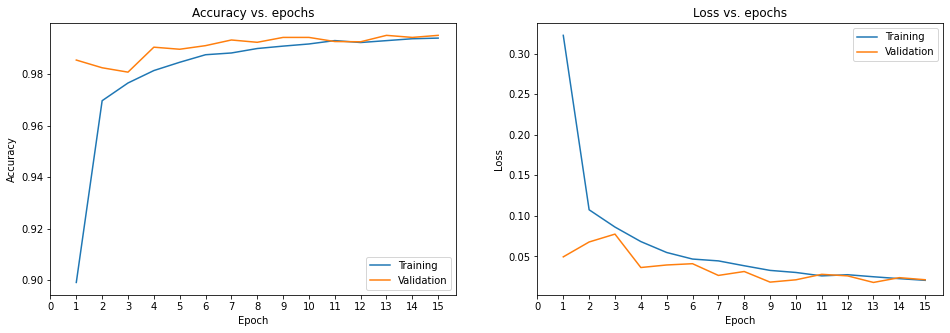

2021-08-10 06:17:38,764: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8
----------------------------------------evaluate----------------------------------------


2021-08-10 06:17:52,363: INFO: test loss:0.0179
2021-08-10 06:17:52,364: INFO: test accuracy:0.9951
2021-08-10 06:17:52,367: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:17:52,368: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:17:52,369: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:17:52,370: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:17:52,371: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:17:53,745: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator


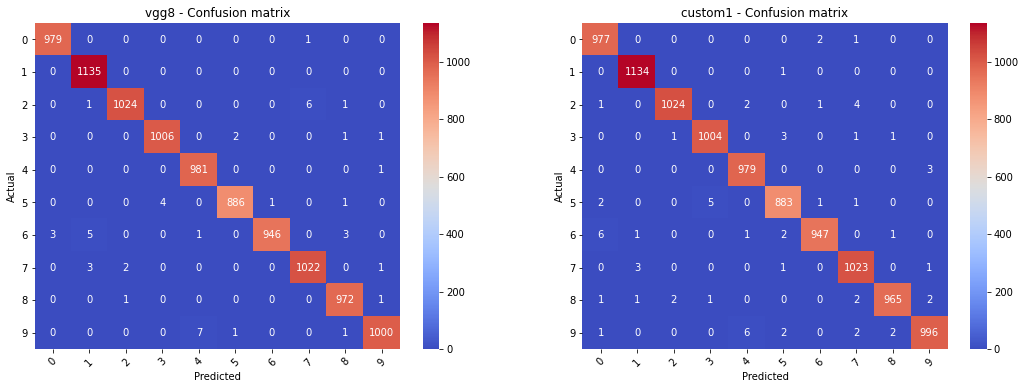

2021-08-10 06:17:57,471: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1


----------------------------------------sample analysis----------------------------------------


2021-08-10 06:17:58,419: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:17:58,422: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
2021-08-10 06:17:59,197: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:17:59,200: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20
2021-08-10 06:18:04,001: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:18:04,005: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/o

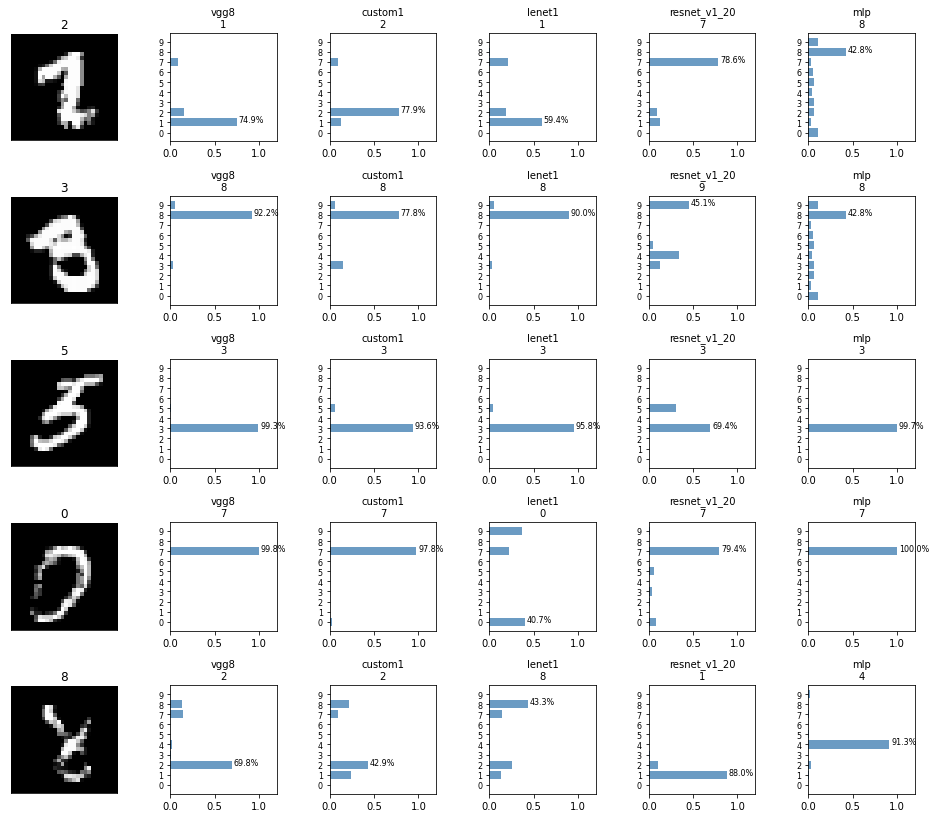

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,279.1,0.0081,0.0179,0.9977,0.9951,1.0000,1.0000
2,custom1,73162,158.1,0.0127,0.0240,0.9960,0.9932,1.0000,1.0000
3,lenet1,61750,137.5,0.0169,0.0269,0.9947,0.9912,1.0000,1.0000
4,resnet_v1_20,272778,602.4,0.0790,0.0854,0.9897,0.9882,0.9999,0.9999
5,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965
6,mlp1,101770,60.6,0.2428,0.3528,0.9392,0.9336,0.9962,0.9944


In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 28, 28, 1), dtype=tf.uint8, name=None)


2021-08-10 06:18:11,091: INFO: learning_rate=0.001
2021-08-10 06:18:11,092: INFO: model_params.resnet_v1_20.clip_value=None
2021-08-10 06:18:11,099: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20
2021-08-10 06:18:11,118: INFO: model_params.resnet_v1_20.epochs=15
2021-08-10 06:18:11,119: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20, monitor=val_accuracy)
2021-08-10 06:18:11,119: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 06:18:11,120: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 06:18:11,121: INFO: use LearningRateScheduler()
2021-08-10 06:18:11,121: INFO: steps_per_epoch=1875
2021-08-10 06:18:11,122: INFO: start training
2021-08-10 06:18:11,122: INFO: use_class_weight=False


Model: "resnet_v1_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 28, 28, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization_5[0][0]      
_______________________________________________________________________________________

1875/1875 [==============================] - 43s 21ms/step - loss: 0.2766 - accuracy: 0.9600 - val_loss: 0.2813 - val_accuracy: 0.9460


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


2021-08-10 06:19:04,486: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


Epoch 2/15
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1615 - accuracy: 0.9837 - val_loss: 0.1873 - val_accuracy: 0.9703


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


2021-08-10 06:20:05,188: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


Epoch 3/15
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1312 - accuracy: 0.9861 - val_loss: 0.1610 - val_accuracy: 0.9734


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


2021-08-10 06:21:01,365: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


Epoch 4/15
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1114 - accuracy: 0.9884 - val_loss: 0.1261 - val_accuracy: 0.9830


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


2021-08-10 06:21:56,973: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


Epoch 5/15
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1008 - accuracy: 0.9891 - val_loss: 0.0993 - val_accuracy: 0.9892


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


2021-08-10 06:22:55,427: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


Epoch 6/15
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0922 - accuracy: 0.9899 - val_loss: 0.1195 - val_accuracy: 0.9817
Epoch 7/15
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0854 - accuracy: 0.9908 - val_loss: 0.0931 - val_accuracy: 0.9883
Epoch 8/15
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0804 - accuracy: 0.9909 - val_loss: 0.0973 - val_accuracy: 0.9858
Epoch 9/15
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0763 - accuracy: 0.9916 - val_loss: 0.1011 - val_accuracy: 0.9851
Epoch 10/15
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0723 - accuracy: 0.9924 - val_loss: 0.0787 - val_accuracy: 0.9896


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


2021-08-10 06:27:11,847: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


Epoch 11/15
1875/1875 [==============================] - 78s 41ms/step - loss: 0.0708 - accuracy: 0.9922 - val_loss: 0.0743 - val_accuracy: 0.9906


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


2021-08-10 06:28:42,062: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


Epoch 12/15
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0664 - accuracy: 0.9930 - val_loss: 0.0845 - val_accuracy: 0.9884
Epoch 13/15
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0656 - accuracy: 0.9928 - val_loss: 0.0832 - val_accuracy: 0.9883
Epoch 14/15
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0617 - accuracy: 0.9932 - val_loss: 0.0817 - val_accuracy: 0.9878
Epoch 15/15
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0601 - accuracy: 0.9936 - val_loss: 0.0676 - val_accuracy: 0.9912


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets


2021-08-10 06:33:51,271: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20/assets
2021-08-10 06:33:52,150: INFO: finish training [elapsed time: 941.03 seconds]


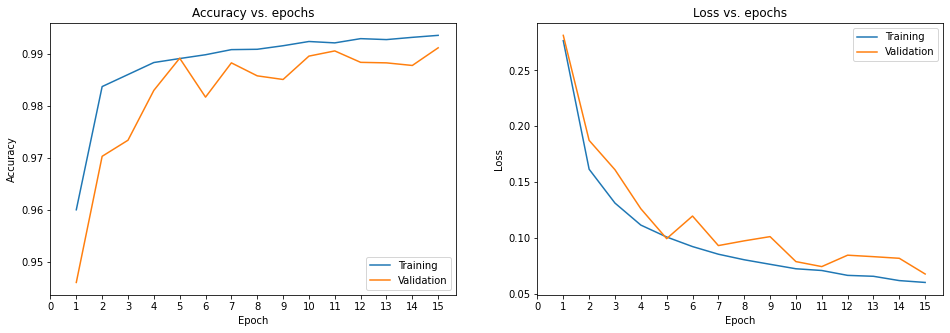

2021-08-10 06:33:52,594: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/resnet_v1_20
----------------------------------------evaluate----------------------------------------


2021-08-10 06:34:29,642: INFO: test loss:0.0676
2021-08-10 06:34:29,643: INFO: test accuracy:0.9912
2021-08-10 06:34:29,649: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:34:29,650: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json
2021-08-10 06:34:29,651: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:34:29,652: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:34:29,653: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 06:34:31,457: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator


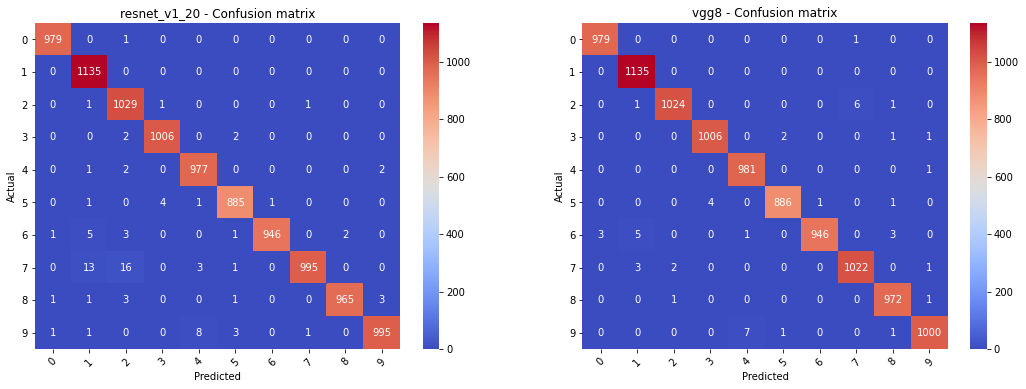

2021-08-10 06:34:36,393: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 06:34:37,896: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:34:37,899: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
2021-08-10 06:34:38,805: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:34:38,807: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
2021-08-10 06:34:40,323: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:34:40,325: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output

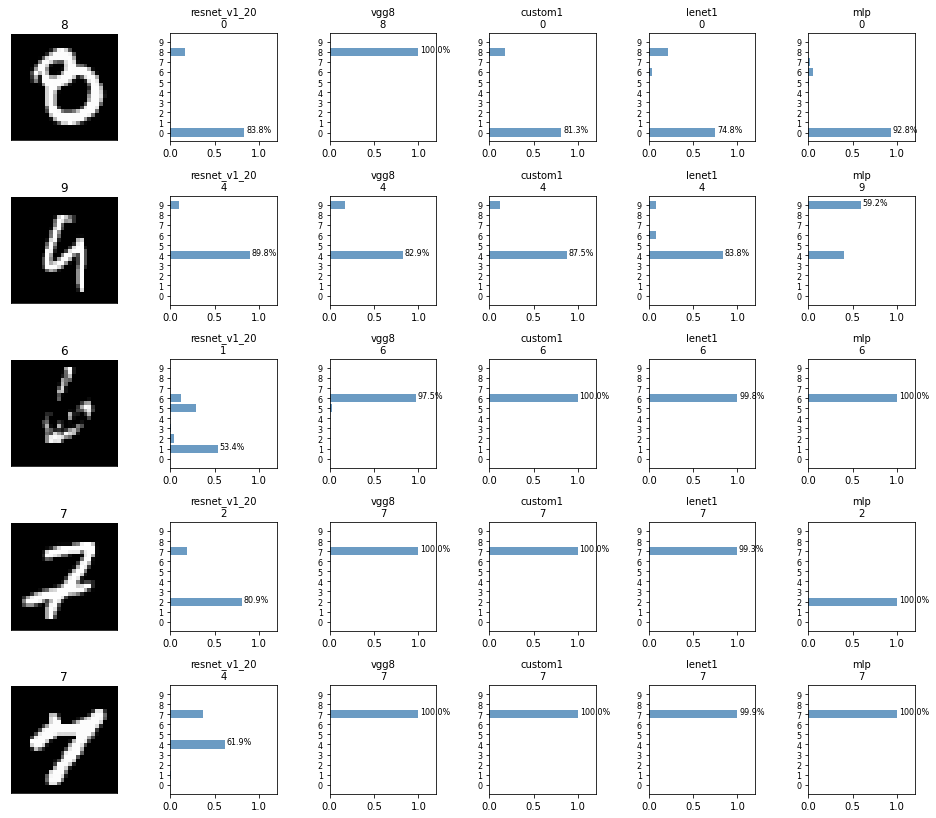

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,279.1,0.0081,0.0179,0.9977,0.9951,1.0000,1.0000
2,custom1,73162,158.1,0.0127,0.0240,0.9960,0.9932,1.0000,1.0000
3,lenet1,61750,137.5,0.0169,0.0269,0.9947,0.9912,1.0000,1.0000
4,resnet_v1_20,272778,940.5,0.0577,0.0676,0.9941,0.9912,1.0000,1.0000
5,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965
6,mlp1,101770,60.6,0.2428,0.3528,0.9392,0.9336,0.9962,0.9944


In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [22]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-08-10 06:34:48,439: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist
2021-08-10 06:34:48,440: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/results.json


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1442378,279.1,0.0081,0.0179,0.9977,0.9951,1.0000,1.0000
2,custom1,73162,158.1,0.0127,0.0240,0.9960,0.9932,1.0000,1.0000
3,lenet1,61750,137.5,0.0169,0.0269,0.9947,0.9912,1.0000,1.0000
4,resnet_v1_20,272778,940.5,0.0577,0.0676,0.9941,0.9912,1.0000,1.0000
5,mlp,101770,61.4,0.1729,0.2884,0.9575,0.9500,0.9981,0.9965
6,mlp1,101770,60.6,0.2428,0.3528,0.9392,0.9336,0.9962,0.9944


2021-08-10 06:34:48,538: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/vgg8
2021-08-10 06:34:50,471: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:34:50,474: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/custom1
2021-08-10 06:34:52,313: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/raw.generator
2021-08-10 06:34:52,316: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mnist_0721_p100/lenet1
2021-08-10 06:34:53,326: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/mnist/mn

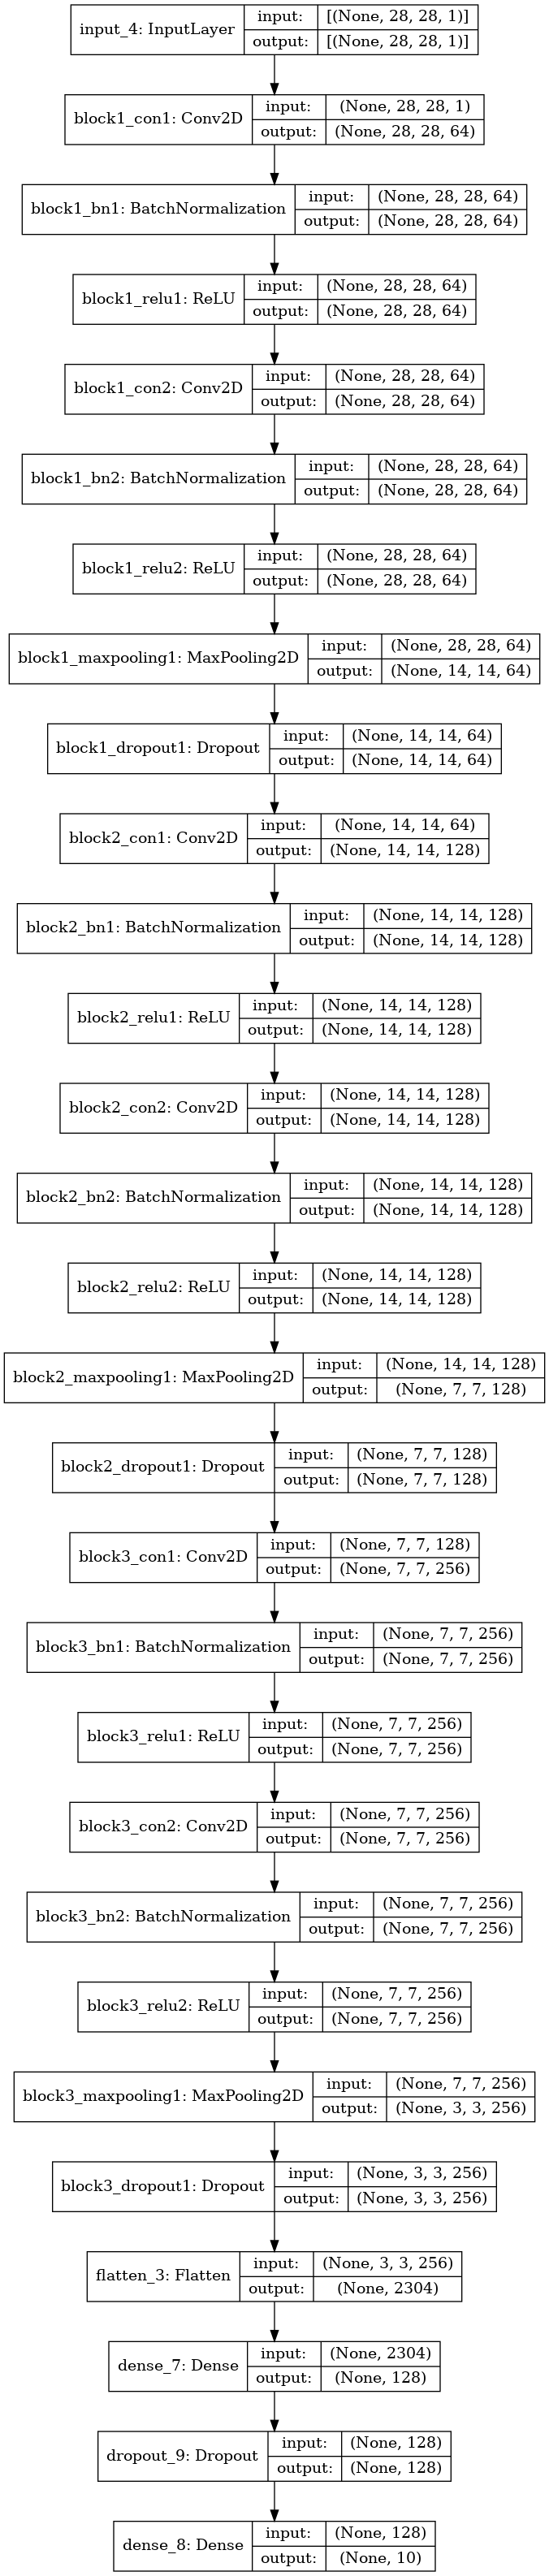

In [23]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

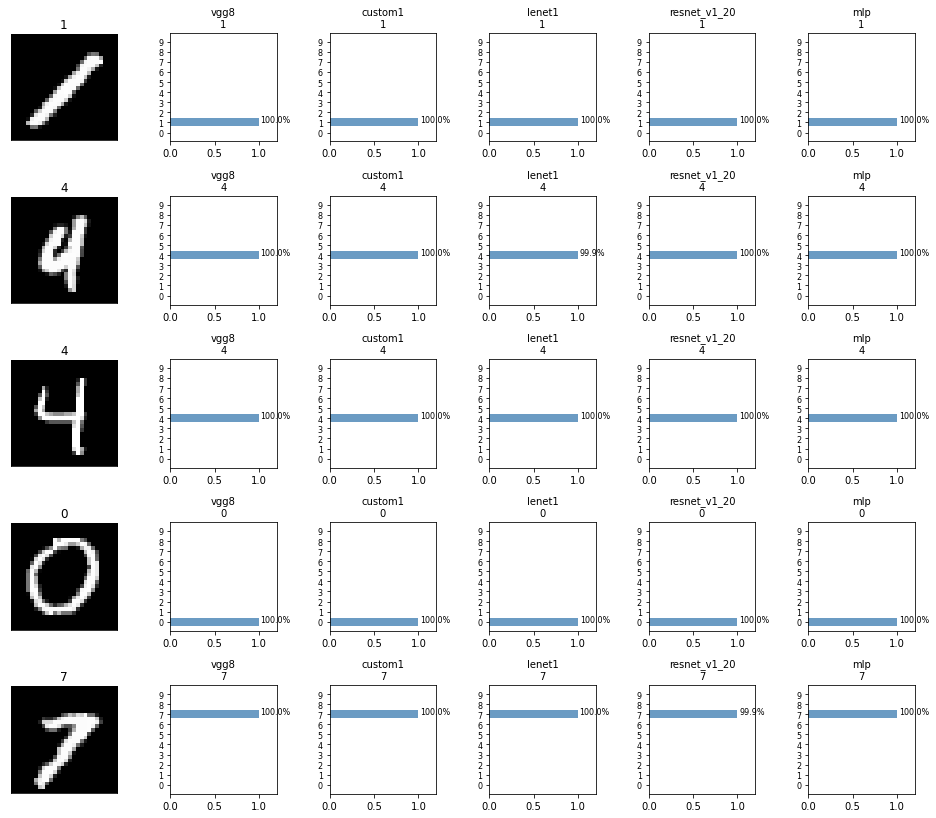

In [24]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

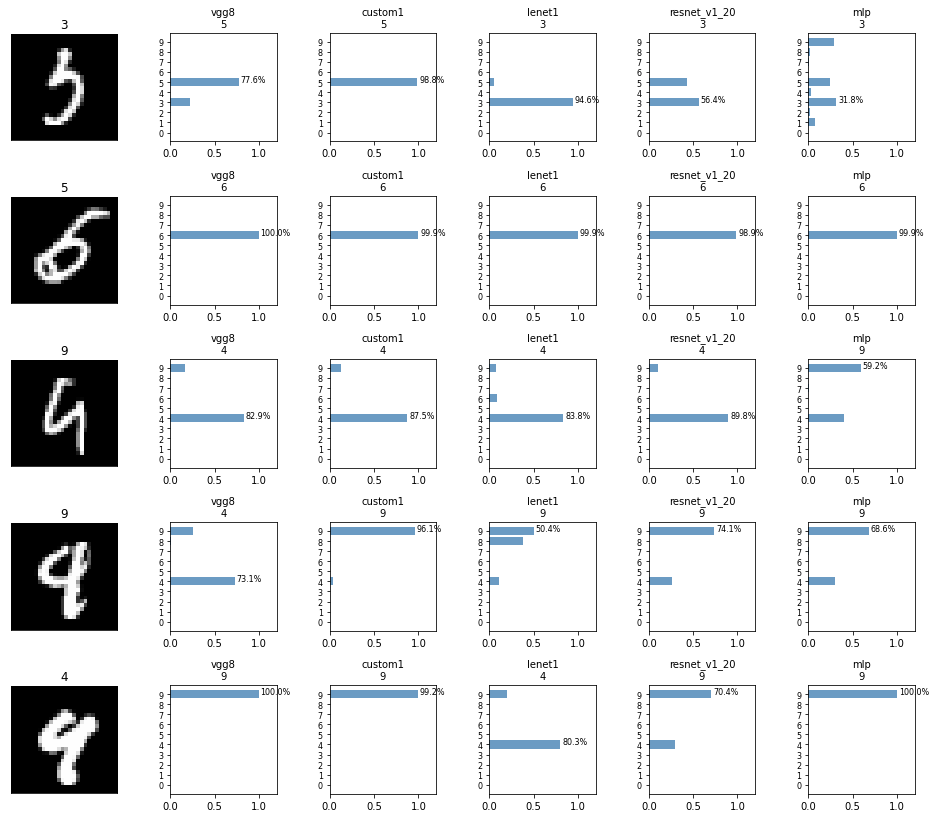

In [25]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [26]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.017905762419104576, 'accuracy': 0.9951000213623047, 'mae': 18.395111083984375}
(10000, 10)


In [27]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
0,0.996945,0.998980,0.997961
1,0.992133,1.000000,0.996051
2,0.997079,0.992248,0.994658
3,0.996040,0.996040,0.996040
4,0.991911,0.998982,0.995434
5,0.996625,0.993274,0.994947
6,0.998944,0.987474,0.993176
7,0.993197,0.994163,0.993680
8,0.992850,0.997947,0.995392
9,0.996016,0.991080,0.993542


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9969    0.9990    0.9980       980
           1     0.9921    1.0000    0.9961      1135
           2     0.9971    0.9922    0.9947      1032
           3     0.9960    0.9960    0.9960      1010
           4     0.9919    0.9990    0.9954       982
           5     0.9966    0.9933    0.9949       892
           6     0.9989    0.9875    0.9932       958
           7     0.9932    0.9942    0.9937      1028
           8     0.9928    0.9979    0.9954       974
           9     0.9960    0.9911    0.9935      1009

    accuracy                         0.9951     10000
   macro avg     0.9952    0.9950    0.9951     10000
weighted avg     0.9951    0.9951    0.9951     10000



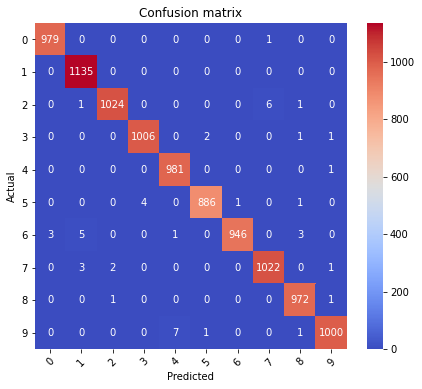

In [28]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [32]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset